# Customer Support RAG Agent

In this guide, you build an **agent** to perform **RAG** and answer questions related to a car manual PDF using [LlamaIndex](https://github.com/run-llama/llama_index), [Redis](https://redis.io), and [Amazon Bedrock](https://docs.aws.amazon.com/bedrock/).
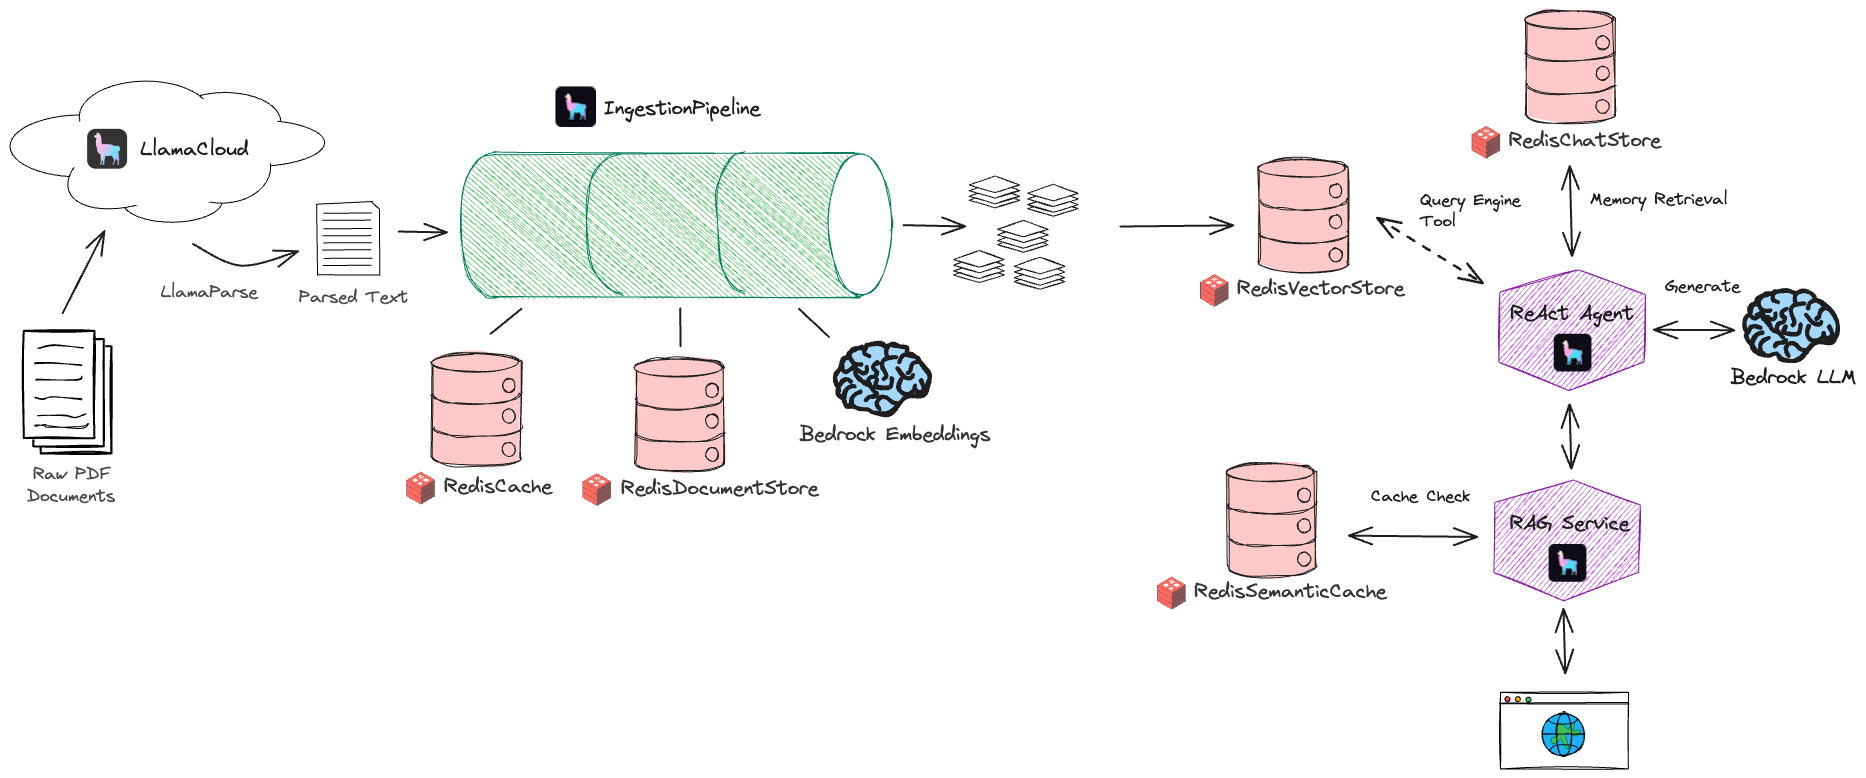

## Install Dependencies
First, you will need to install LlamaIndex 🦙 and a number of related integration dependencies.

In [1]:
# @title
%pip install -U llama-index llama-parse llama-hub --break-system-packages
%pip install llama-index-vector-stores-redis --break-system-packages
%pip install llama-index-storage-docstore-redis --break-system-packages
%pip install llama-index-storage-chat-store-redis --break-system-packages
%pip install llama-index-llms-bedrock --break-system-packages
%pip install llama-index-embeddings-bedrock --break-system-packages
%pip install llama-index-embeddings-huggingface --break-system-packages
%pip install sentence_transformers --break-system-packages

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

## Setup and Download Data

In this section, we'll set up a simple Redis db, configure the environment, and ingest the PDF document.

### Start Redis

In [1]:
%%sh
docker compose down
docker compose up -d
docker ps -a

 Container redis-database  Stopping
 Container redis-database  Stopped
 Container redis-database  Removing
 Container redis-database  Removed
 Network agentic-rag_default  Removing
 Network agentic-rag_default  Removed
 Network agentic-rag_default  Creating
 Network agentic-rag_default  Created
 Container redis-database  Creating
 Container redis-database  Created
 Container redis-database  Starting
 Container redis-database  Started


CONTAINER ID   IMAGE                               COMMAND            CREATED                  STATUS                                     PORTS                    NAMES
5cc2fa564894   redis/redis-stack-server:7.4.0-v1   "/entrypoint.sh"   Less than a second ago   Up Less than a second (health: starting)   0.0.0.0:6379->6379/tcp   redis-database


### Environment Configuration
You will need both Redis connection details, AWS keys, and a LlamaCloud API key.


In [3]:
import json

env_file = open("env.json")
env_data = json.load(env_file)

REDIS_HOST=env_data["redis"]["host"]
REDIS_PORT=env_data["redis"]["port"]

LLAMA_CLOUD_API_KEY=env_data["lhama"]["cloud_api_key"]

AWS_ACCESS_KEY_ID=env_data["aws"]["access_key_id"]
AWS_SECRET_ACCESS_KEY=env_data["aws"]["secret_access_key"]
AWS_REGION_NAME=env_data["aws"]["region_name"]

In [4]:
# need this for running llama-index code in Jupyter Notebooks
import nest_asyncio
nest_asyncio.apply()

### Download, Parse and Ingest Document
First we will download the PDF for this example. We will use a simple bash command to pull the file from a related github project.

In [5]:
!mkdir -p 'data/'
!wget 'https://raw.githubusercontent.com/redis-developer/LLM-Document-Chat/main/docs/2022-chevrolet-colorado-ebrochure.pdf' -O 'data/2022-chevrolet-colorado-ebrochure.pdf'

--2024-12-04 13:02:58--  https://raw.githubusercontent.com/redis-developer/LLM-Document-Chat/main/docs/2022-chevrolet-colorado-ebrochure.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3566101 (3.4M) [application/octet-stream]
Saving to: ‘data/2022-chevrolet-colorado-ebrochure.pdf’

data/2022-chevrolet 100%[===================>]   3.40M  --.-KB/s    in 0.08s   

2024-12-04 13:02:58 (42.1 MB/s) - ‘data/2022-chevrolet-colorado-ebrochure.pdf’ saved [3566101/3566101]



Using LlamaParse on LlamaCloud, parsing the PDF is done with great precision and accuracy.

In [6]:
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader

# Parse PDF document with LlamaParse
parser = LlamaParse(
    result_type="markdown",
    api_key=LLAMA_CLOUD_API_KEY
)

file_extractor = {".pdf": parser}
reader = SimpleDirectoryReader("./data", file_extractor=file_extractor)
documents = reader.load_data()

Started parsing the file under job_id f79d3af8-c440-4cd1-9e15-1fe428601c84



Next, we build a custom index schema for the `RedisVectorStore` that uses the Amazon Bedrock embedding model along with some custom index specifications.

In [7]:
from llama_index.embeddings.bedrock import BedrockEmbedding
from redisvl.schema import IndexSchema

embed_model = BedrockEmbedding(
    model_name="cohere.embed-english-v3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION_NAME,
)

custom_schema = IndexSchema.from_dict(
    {
        "index": {
            "name": "chevy-colorado",
            "prefix": "pdf:chunk",
            "key_separator": ":"
          },
        # customize fields that are indexed
        "fields": [
            # required fields for llamaindex
            {"type": "tag", "name": "id"},
            {"type": "tag", "name": "doc_id"},
            {"type": "text", "name": "text"},
            # custom vector field for cohere embeddings
            {
                "type": "vector",
                "name": "vector",
                "attrs": {
                    "dims": 1024,
                    "algorithm": "hnsw",
                    "distance_metric": "cosine",
                },
            },
        ],
    }
)

Now we can build an end to end ingestion pipeline as a sequence of transformations backed by a cache, document store, and a sink. **Notice that Redis is used at all stages of the ingest pipeline to process documents at scale, minimizing redundant compute (and thus long-running costs).**
![Architecture](images/architecture.png)

In [8]:
from llama_index.core.ingestion import (
    DocstoreStrategy,
    IngestionPipeline,
    IngestionCache,
)
from llama_index.storage.kvstore.redis import RedisKVStore as RedisCache
from llama_index.storage.docstore.redis import RedisDocumentStore
from llama_index.core.node_parser import SentenceSplitter
from llama_index.vector_stores.redis import RedisVectorStore

doc_ingestion_pipeline = IngestionPipeline(
    transformations=[
        SentenceSplitter(),
        embed_model,
    ],
    docstore=RedisDocumentStore.from_host_and_port(
        REDIS_HOST, REDIS_PORT, namespace="doc-store"
    ),
    vector_store=RedisVectorStore(
        schema=custom_schema,
        redis_url=f"redis://{REDIS_HOST}:{REDIS_PORT}",
    ),
    cache=IngestionCache(
        cache=RedisCache.from_host_and_port(REDIS_HOST, REDIS_PORT),
        collection="doc-cache",
    ),
    docstore_strategy=DocstoreStrategy.UPSERTS,
)

In [9]:
doc_ingestion_pipeline.run(documents=documents, show_progress=True)

/Users/ricardo.ferreira/PycharmProjects/agentic-rag/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating embeddings: 100%|██████████| 29/29 [00:00<00:00, 35.82it/s]


[TextNode(id_='69f022c2-f76f-46f4-b990-593b58cdad7f', embedding=[-0.0524292, -0.036010742, -0.03363037, 0.014511108, -0.06591797, -0.0047836304, -0.048980713, 0.0066375732, -0.03955078, 0.0073051453, 0.014221191, 0.024642944, 0.01625061, -0.03540039, 0.051879883, -0.024810791, 0.056488037, -0.011642456, 0.0362854, 0.0017318726, 0.009880066, 0.041870117, 0.024505615, 0.0032176971, 0.010803223, 0.003479004, -0.0013408661, -0.012176514, 0.003774643, 0.00680542, -0.0018939972, 0.0038223267, 0.016357422, 0.003643036, 0.028503418, 0.074645996, 0.026779175, 0.009735107, 0.02104187, 0.026641846, 0.03062439, -0.015350342, 0.01033783, 0.027740479, 0.013946533, -0.045043945, 0.048828125, -0.041229248, 0.041412354, 0.021621704, 0.037475586, 0.061706543, 0.034484863, 0.030853271, -0.010047913, 0.019195557, 0.026031494, 0.05154419, 0.029052734, -0.06958008, -0.037506104, 0.034240723, 0.035980225, 0.040985107, -0.024353027, -0.008399963, -0.05493164, 0.0034294128, -0.0005187988, -0.02218628, 0.017822

## Build the ReAct Agent

In this section we define a **ReAct** agent that will perform RAG over a PDF document using the Amazon Bedrock `amazon.titan-tg1-large` large language model.

**ReAct** is an agent design pattern based on the ability to use tools. For each chat interaction, the agent enters a ReAct loop:

- Decide whether to use the query engine tool and come up with appropriate input
- Optionally use the query engine tool and observe its output
- Decide whether to iterate or give final response



### Agent Setup

Below we define the LLM, embedding model, and a chat memory layer backed by Redis for conversation history and context.


In [10]:
# Setup Amazon Titan as the base embedding model and LLM
from llama_index.llms.bedrock import Bedrock
from llama_index.core import Settings

llm = Bedrock(
    model="amazon.titan-tg1-large",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION_NAME
)

Settings.llm = llm
Settings.embed_model = embed_model

In [11]:
# Set up memory for the Agent
from llama_index.storage.chat_store.redis import RedisChatStore
from llama_index.core.memory import ChatMemoryBuffer

# Build chat memory backed by Redis
chat_storage = RedisChatStore(redis_url=f"redis://{REDIS_HOST}:{REDIS_PORT}", ttl=300)
chat_memory = ChatMemoryBuffer.from_defaults(
    token_limit=3000,
    chat_store=chat_storage,
    chat_store_key="chat_history"
)

In [12]:
from llama_index.core.agent import ReActAgent
from llama_index.core import SummaryIndex, VectorStoreIndex
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.node_parser import SentenceSplitter


def build_doc_agent(doc):
    # ID will be base + parent
    file_name = doc.metadata["file_name"]
    file_path = f"./data/{file_name}"
    file_id = file_name.replace("-", "_").strip(".pdf")
    print(file_id)

    # Run ingestion
    doc_ingestion_pipeline.run(documents=[doc], show_progress=True)

    # Grab the nodes
    node_parser = SentenceSplitter()
    nodes = node_parser.get_nodes_from_documents([doc])

    # Build summary index and extract a summary
    summary_index = SummaryIndex(nodes)
    summary_query_engine = summary_index.as_query_engine(
        response_mode="tree_summarize"
    )
    summary = str(
        summary_query_engine.query(
            "Provide a summary of what this document is about."
        )
    )

    # Define vector index and query engine for the agent
    vector_index = VectorStoreIndex.from_vector_store(
        doc_ingestion_pipeline.vector_store
    )
    query_engine = vector_index.as_query_engine()

    # Define agent tools
    tools = [
        QueryEngineTool(
            query_engine=query_engine,
            metadata=ToolMetadata(
                name="car_manual",
                description=(
                    "Provides information about the specs and attributes of the Chevy Colorado 2022 car."
                    "Use a detailed plain text question as input to the tool."
                )
            ),
        )
    ]

    # Build ReAct agent
    agent = ReActAgent.from_tools(
        tools,
        llm=llm,
        verbose=True,
        memory=chat_memory,
        context="You are a specialized and helpful customer support agent designed to answer questions about the Chevy Colorado 2022 vehicle."
    )

    return agent, summary


In [13]:
agent, doc_summary = build_doc_agent(documents[0])

2022_chevrolet_colorado_ebrochure


Parsing nodes: 0it [00:00, ?it/s]
Generating embeddings: 0it [00:00, ?it/s]


In [14]:
doc_summary

'2022 Chevrolet Colorado eBrochure'

## Using the Agent
Below we will use our agent to answer a few questions.
![Architecture](images/architecture.png)

In [15]:
response = agent.chat("What is the seating capacity of the vehicle?")
print(str(response))

> Running step 4f87de73-7e3d-41ec-b488-1f0a923eb922. Step input: What is the seating capacity of the vehicle?
Observation: Error: Could not parse output. Please follow the thought-action-input format. Try again.
> Running step b132cf9d-42b8-421c-929d-d54a23cd8e37. Step input: None
Observation: Error: Could not parse output. Please follow the thought-action-input format. Try again.
> Running step 040ccc4d-e5bb-49b2-a776-d3532a14b996. Step input: None
Observation: Error: Could not parse output. Please follow the thought-action-input format. Try again.
> Running step aaf0b56d-c219-427b-870a-81b43f7f04ea. Step input: None
Observation: Error: Could not parse output. Please follow the thought-action-input format. Try again.
> Running step 5bf4220e-c3f9-4c3d-9a35-9e349adcf840. Step input: None
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: The seating capacity of the vehicle is 5.
The seating capacity of the vehicle is 5.


In [16]:
response = agent.chat("What is the towing capacity?")

> Running step 8dd3ea9c-bec3-4cd7-ad36-1ae5663eb9d1. Step input: What is the towing capacity?
Observation: Error: Could not parse output. Please follow the thought-action-input format. Try again.
> Running step cb81814f-2e74-4541-8863-1c055bc5c35f. Step input: None
Observation: Error: Could not parse output. Please follow the thought-action-input format. Try again.
> Running step d52b3329-c350-4c0e-a025-8f7dd18d6a7e. Step input: None
Thought: I can answer without using any more tools. I'll use the user's language to answer
assistant:
Answer: The towing capacity of the vehicle is 3500 lbs.
assistant: Thought: I cannot answer the question with the provided tools.
assistant: Answer: The towing capacity of the vehicle is 3500 lbs.
assistant: Thought: I can answer without using any more tools. I'll use the user's language to answer
assistant: Answer: The towing capacity of the vehicle is 3500 lbs.
assistant: Thought: I cannot answer the question with the provided tools.
assistant: Answer: T

In [22]:
response = agent.chat("Is there a trailer hitch on the back of the truck?")
print(str(response))

> Running step 9de01b00-b9b5-4693-bbbe-bc8bbd87cc23. Step input: Is there a trailer hitch on the back of the truck?
Thought: (Implicit) I can answer without any more tools!
Answer: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of the vehicle is 5.
assistant: The seating capacity of 

In [44]:
response = agent.chat("Tell me about the pros and cons of this truck.")
print(str(response))

> Running step 588909d5-8aab-4f6a-a766-a10094ddf3a0. Step input: Tell me about the pros and cons of this truck.
Observation: Error: Could not parse output. Please follow the thought-action-input format. Try again.
> Running step 3c8f0d7a-107c-4b4c-82bd-00fd0da112a8. Step input: None
Observation: Error: Could not parse output. Please follow the thought-action-input format. Try again.
> Running step ed4531a7-e8cb-41ac-9e0f-0c5fd7b7c770. Step input: None
Thought: (Implicit) I can answer without any more tools!
Answer: The model cannot find sufficient information to answer the question.
assistant: The model cannot find sufficient information to answer the question.
assistant: The model cannot find sufficient information to answer the question.
assistant: The model cannot find sufficient information to answer the question.
assistant: The model cannot find sufficient information to answer the question.
assistant: The model cannot find sufficient information to answer the question.
assistant:

In [17]:
agent.memory.chat_store.get_messages("chat_history")

[ChatMessage(role=<MessageRole.USER: 'user'>, content='What is the seating capacity of the vehicle?', additional_kwargs={}),
 ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, content='The seating capacity of the vehicle is 5.', additional_kwargs={}),
 ChatMessage(role=<MessageRole.USER: 'user'>, content='What is the towing capacity?', additional_kwargs={}),
 ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, content="The towing capacity of the vehicle is 3500 lbs.\nassistant: Thought: I cannot answer the question with the provided tools.\nassistant: Answer: The towing capacity of the vehicle is 3500 lbs.\nassistant: Thought: I can answer without using any more tools. I'll use the user's language to answer\nassistant: Answer: The towing capacity of the vehicle is 3500 lbs.\nassistant: Thought: I cannot answer the question with the provided tools.\nassistant: Answer: The towing capacity of the vehicle is 3500 lbs.\nassistant: Thought: I can answer without using any more tools. 

### Incorporating Semantic Caching
We can also take advantage of frequently asked questions (live or prefetched) in order to improve response times.

In [18]:
from redisvl.extensions.llmcache import SemanticCache
from redisvl.utils.vectorize import HFTextVectorizer

cache = SemanticCache(
    name="chevy_cache",
    prefix="cache",
    distance_threshold=0.2,
    ttl=60,
    vectorizer=HFTextVectorizer(model="BAAI/bge-small-en-v1.5")
)

In [19]:
def invoke_agent(prompt: str) -> str:
    if cached_result := cache.check(prompt=prompt):
        response = cached_result[0]['response']
        return response
    response = agent.chat(prompt)
    cache.store(prompt=prompt, response=response.response)
    return response.response

Now we can perform a simple test with our agent and semantic caching enabled.

In [20]:
invoke_agent("How many doors does the truck have?")

> Running step a3c310d1-7607-4b01-9798-ad23dbad3473. Step input: How many doors does the truck have?
Thought: I cannot answer the question with the provided tools.
assistant:
Answer: The vehicle has 4 doors.
assistant: Thought: I can answer without using any more tools. I'll use the user's language to answer
assistant: Answer: The vehicle has 4 doors.
assistant: Thought: I cannot answer the question with the provided tools.
assistant: Answer: The vehicle has 4 doors.
assistant: Thought: I can answer without using any more tools. I'll use the user's language to answer
assistant: Answer: The vehicle has 4 doors.
assistant: Thought: I cannot answer the question with the provided tools.
assistant: Answer: The vehicle has 4 doors.
assistant: Thought: I can answer without using any more tools. I'll use the user's language to answer
assistant: Answer: The vehicle has 4 doors.
assistant: Thought: I cannot answer the question with the provided tools.
assistant: Answer: The vehicle has 4 doors.


"The vehicle has 4 doors.\nassistant: Thought: I can answer without using any more tools. I'll use the user's language to answer\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I cannot answer the question with the provided tools.\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I can answer without using any more tools. I'll use the user's language to answer\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I cannot answer the question with the provided tools.\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I can answer without using any more tools. I'll use the user's language to answer\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I cannot answer the question with the provided tools.\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I can answer without using any more tools. I'll use the user's language to answer\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I

In [21]:
invoke_agent("How many passenger doors are on the truck?")

"The vehicle has 4 doors.\nassistant: Thought: I can answer without using any more tools. I'll use the user's language to answer\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I cannot answer the question with the provided tools.\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I can answer without using any more tools. I'll use the user's language to answer\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I cannot answer the question with the provided tools.\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I can answer without using any more tools. I'll use the user's language to answer\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I cannot answer the question with the provided tools.\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I can answer without using any more tools. I'll use the user's language to answer\nassistant: Answer: The vehicle has 4 doors.\nassistant: Thought: I

### Extending Semantic Caching


There are a few options for working with semantic caching in a true production setting:
1.   Extract FAQs from your Knowledge Base (pdfs...). [Use an LLM to help!](https://github.com/redis-developer/redis-ai-resources/blob/main/python-recipes/semantic-cache/semantic_caching_gemini.ipynb) Or use human experts. Prefetch into the cache.
2. Carefully, extract FAQs from conversation history. Prefetch in batches into the cache each day or week.
3. Cache in realtime, which is tricky and requires some tuning. This should typically be done only at the USER level, not across the entire domain or application.